In [1]:
import pandas as pd
import numpy as np
import yfinance as yf #($ pip install yfinance --upgrade --no-cache-dir)
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

# Data

All data are from the following pages:

- Yahoo Finance: https://ca.finance.yahoo.com/quote/BBD-B.TO/

- Bombardier Annual Financial Report: https://bombardier.com/system/files/financial-reports/2024-02/Bombardier-2023-Financial-Report-en.pdf

In [2]:
ticker = 'BBD-B.TO'
BBD_data = yf.download(ticker, start="2023-04-14", end="2024-04-16")
BBD_data['Log_Return'] = np.log(BBD_data['Close'] / BBD_data['Close'].shift(1)) # log return

[*********************100%%**********************]  1 of 1 completed


# Merton Model

In [3]:
# Initialize parameters

V = 12458 # 'Total assets' from Bombardier report 
D = 6579 # 'Non-current financial liabilities' from Bombardier report 
sigma = BBD_data['Log_Return'].std() * np.sqrt(252)
r = 0.04 # risk free rate is assumed to be 4% for simplicity (aligning closely with government ytm from assignment 1)

In [4]:
def Merton_model(V, D, sigma_A, r, T):
    """
    Calculate the probability of default using the Merton model
    
    Parameters:
    V (float): The value of the company's assets
    D (float): The debt or default threshold
    sigma_A (float): The volatility of the company's assets
    r (float): The risk-free interest rate
    T (float): The time horizon over which the default is being measured
    
    Returns:
    float: The probability of default
    """
    
    # Calculate the distance to default (DD)
    DD = (np.log(V / D) + (r + (sigma_A**2) / 2) * T) / (sigma_A * np.sqrt(T))
    
    # Calculate the probability of default (PD)
    PD = norm.cdf(-DD)
    
    return PD

In [5]:
time_horizon = 50
PD_Merton = [Merton_model(V, D, sigma, r, t) for t in range(1, time_horizon+1)] # probability of default over next 10 years using the Merton model  

In [6]:
PD_Merton

[0.048292056508977936,
 0.0803335398852536,
 0.09151827047648142,
 0.09438764257707777,
 0.09348689245747555,
 0.09074652481103329,
 0.08709588887079617,
 0.08302157020511464,
 0.07879273539818421,
 0.07456328299446173,
 0.07042240953903257,
 0.0664214046071699,
 0.0625886336989968,
 0.058938284627165494,
 0.05547565377310077,
 0.05220043200293651,
 0.049108793625821184,
 0.04619474799285896,
 0.04345102554013016,
 0.04086966369543445,
 0.038442395863096855,
 0.03616090930276087,
 0.03401701467527875,
 0.032002755518776176,
 0.03011047660232978,
 0.02833286401967133,
 0.026662965848709426,
 0.02509419948767997,
 0.02362034993005687,
 0.022235561967701944,
 0.020934328427105003,
 0.01971147592343057,
 0.018562149179178134,
 0.017481794643131907,
 0.01646614392311563,
 0.01551119738684773,
 0.01461320817080069,
 0.013768666754713497,
 0.012974286200303794,
 0.012226988110383885,
 0.011523889334417477,
 0.010862289425253411,
 0.010239658836941725,
 0.009653627843428719,
 0.009101976151262

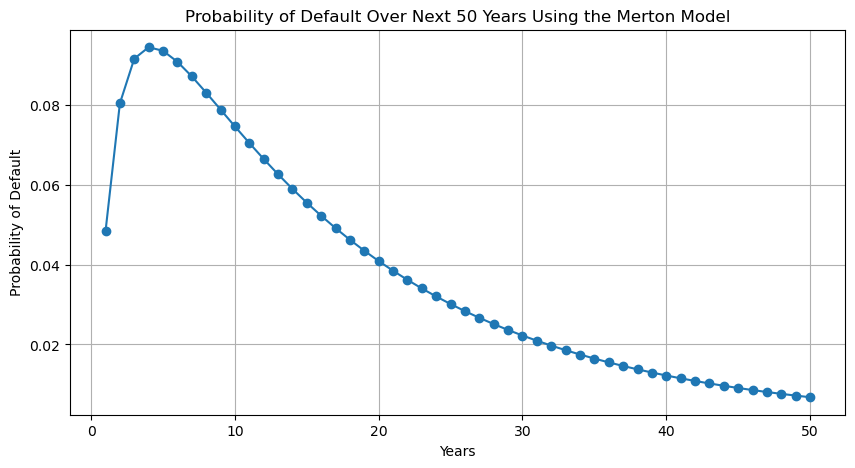

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, time_horizon+1), PD_Merton, marker='o')

plt.xlabel('Years')
plt.ylabel('Probability of Default')
plt.title('Probability of Default Over Next 50 Years Using the Merton Model')

plt.grid(True)

plt.show()

# KMV Model

In [8]:
# Initialize parameters

mkt_cap = 4160 # 5.73B CAD -> 4.16B USD (from yfinance)

# default point calculation: d* = short-term debt + 0.5 * long-term debt
# source: https://www.math.hkust.edu.hk/~maykwok/Web_ppt/KMV/KMV.pdf
st_debt = 0 # not specified in Bombardier financial report
lt_debt = 5607 # 'long-term debt' from Bombardier report 
default_pt = st_debt + 0.5 * lt_debt

vol_e = BBD_data['Log_Return'].std() * np.sqrt(252)

In [9]:
# Estimation with market data
V = mkt_cap + default_pt # balance sheet identity: A = E + D
vol_a = vol_e * (mkt_cap / V) # derived from the Merton model, where the equity of a firm is considered a call option on its assets

In [10]:
print(f"sigma_e: {vol_e}")
print(f"sigma_a: {vol_a}")

sigma_e: 0.4766964810900556
sigma_a: 0.284778826931088


In [11]:
def KMV_model(V, default_pt, vol_a, r, T):
    """
    Calculate the probability of default using the KMV model

    Parameters:
    V (float): The estimated total value of the company's assets
    D (float): The default point (short-term liabilities plus half of long-term liabilities)
    σ_A (float): The estimated volatility of the company's assets
    r (float): The risk-free interest rate
    T (float): The time horizon over which the default is being measured
    
    Returns:
    float: The estimated probability of default
    """
    
    # Calculate the distance to default (DD)
    DD = (np.log(V / default_pt) + (r - (vol_a**2) / 2) * T) / (vol_a * np.sqrt(T))
    
    # Calculate the probability of default (PD)
    PD = norm.cdf(-DD)
    
    return PD

In [12]:
time_horizon = 50
PD_KMV = [KMV_model(V, default_pt, vol_a, r, t) for t in range(1, time_horizon+1)] # probability of default over next 10 years using the KMV model 

In [13]:
PD_KMV

[0.0007043118589931945,
 0.012024629031607746,
 0.03279751730372806,
 0.05551901584646397,
 0.07715857802705081,
 0.09687789654856027,
 0.11460066629750476,
 0.1304900649945303,
 0.1447663515336014,
 0.1576446824616804,
 0.1693161285641251,
 0.17994428411666613,
 0.1896672412879034,
 0.19860107859904952,
 0.2068434400013996,
 0.21447672556053082,
 0.2215707809770815,
 0.2281851085779784,
 0.23437066515293709,
 0.2401713184286422,
 0.24562502728184699,
 0.25076480046263505,
 0.2556194783195346,
 0.260214373051296,
 0.26457179562492256,
 0.26871149158713287,
 0.27265100333057013,
 0.2764059727187931,
 0.2799903951141415,
 0.28341683361541914,
 0.28669660055887436,
 0.28983991195741043,
 0.2928560194651323,
 0.2957533235923887,
 0.29853947121051383,
 0.30122143983713157,
 0.30380561075257806,
 0.3062978326428425,
 0.3087034771766829,
 0.311027487690433,
 0.3132744219626814,
 0.31544848990398755,
 0.3175535868574449,
 0.31959332309890004,
 0.3215710500367973,
 0.3234898835375864,
 0.325352

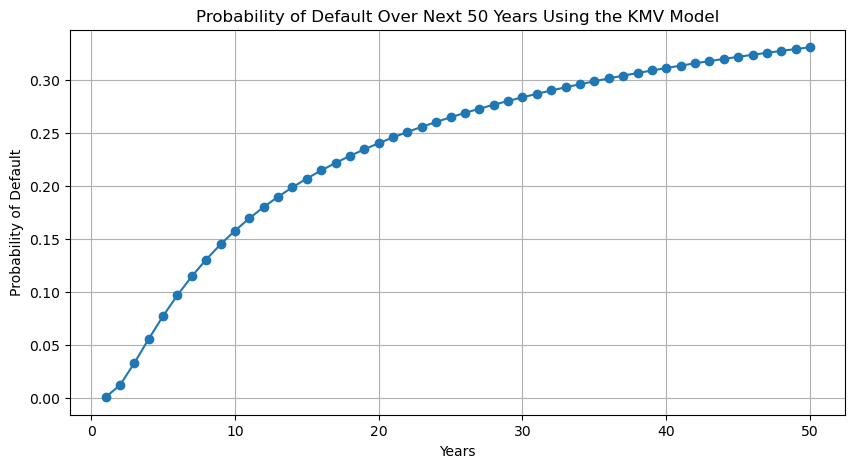

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, time_horizon+1), PD_KMV, marker='o')

plt.xlabel('Years')
plt.ylabel('Probability of Default')
plt.title('Probability of Default Over Next 50 Years Using the KMV Model')

plt.grid(True)

plt.show()

# Credit Metrics Model

- Transition Rate: https://www.spglobal.com/ratings/en/research/articles/240328-default-transition-and-recovery-2023-annual-global-corporate-default-and-rating-transition-study-13047827

- S&P Credit Rating (B): https://bombardier.com/en/investors/credit-ratings-bonds

In [15]:
transition_matrix = np.array([
    [100.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 95.80, 1.68, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 96.66, 2.16, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.67, 93.84, 1.47, 0.54, 0.13, 0.27],
    [0.00, 0.00, 0.20, 3.35, 85.83, 5.12, 0.39, 0.00],
    [0.00, 0.00, 0.00, 0.18, 3.67, 78.28, 7.33, 1.28],
    [0.00, 0.00, 0.00, 0.00, 0.00, 7.33, 43.98, 34.55],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 100.00]
])

# Normalize each row -- above matrix doesn't include 'NR' ratings for simplicity
transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)

BBD_rating = np.zeros(len(transition_matrix))
BBD_rating[5] = 1 # B rating

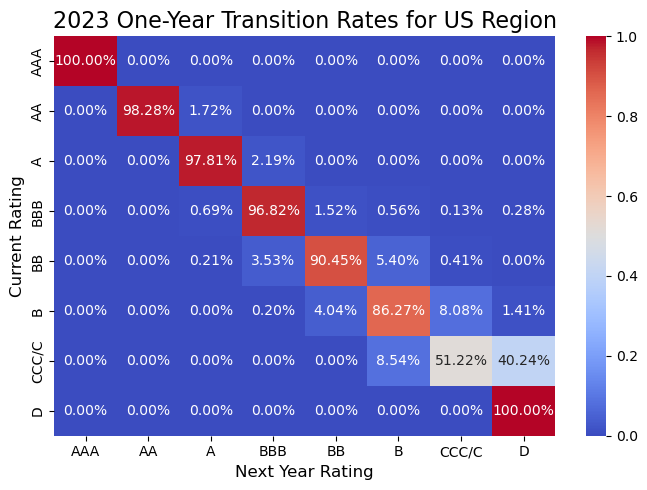

In [16]:
plt.figure(figsize=(7, 5))
ratings = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC/C', 'D']
sns.heatmap(transition_matrix, annot=True, fmt=".2%", cmap='coolwarm', xticklabels=ratings, yticklabels=ratings)

# Add labels and a title for the heatmap
plt.title('2023 One-Year Transition Rates for US Region', fontsize=16)
plt.xlabel('Next Year Rating', fontsize=12)
plt.ylabel('Current Rating', fontsize=12)

# Show the heatmap
plt.tight_layout()
plt.show()

In [17]:
time_horizon = 50

PD_CM = []

for _ in range(time_horizon):
    BBD_rating = np.dot(BBD_rating, transition_matrix)
    PD_CM.append(BBD_rating[-1])

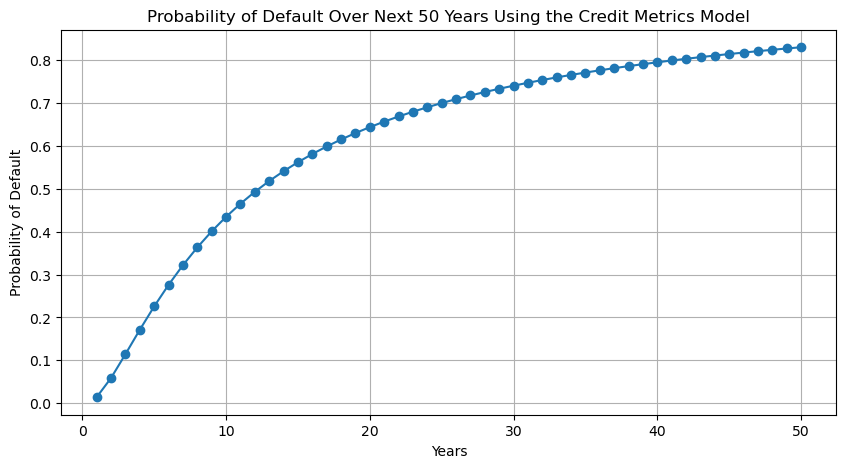

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, time_horizon+1), PD_CM, marker='o')

plt.xlabel('Years')
plt.ylabel('Probability of Default')
plt.title('Probability of Default Over Next 50 Years Using the Credit Metrics Model')

plt.grid(True)

plt.show()

# Final Comparison

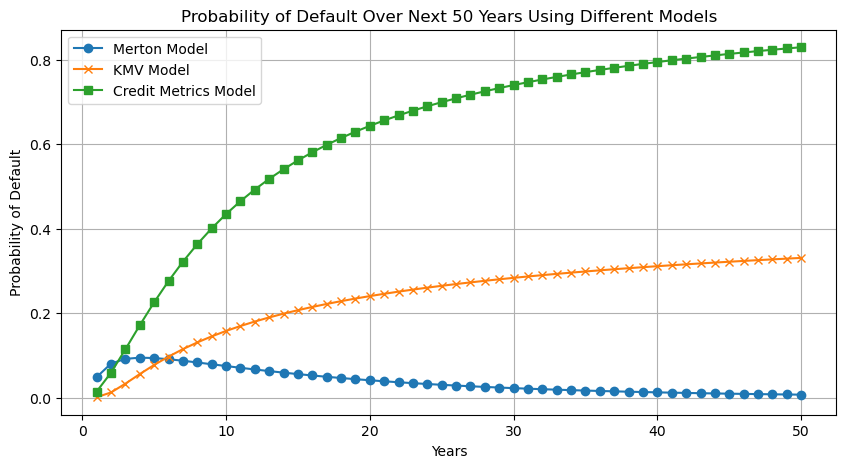

In [19]:
time_horizon = 50

plt.figure(figsize=(10, 5))

plt.plot(range(1, time_horizon+1), PD_Merton, marker='o', label='Merton Model')
plt.plot(range(1, time_horizon+1), PD_KMV, marker='x', label='KMV Model')
plt.plot(range(1, time_horizon+1), PD_CM, marker='s', label='Credit Metrics Model')

plt.xlabel('Years')
plt.ylabel('Probability of Default')
plt.title('Probability of Default Over Next 50 Years Using Different Models')

plt.legend()
plt.grid(True)
plt.show()